## Title: ASL Recognition Using MobileNetV2

### Introduction to American Sign Language (ASL)
"""
American Sign Language (ASL) is a visual language that serves as the primary language of many deaf and hard-of-hearing individuals in North America. Unlike spoken languages, ASL uses hand shapes, facial expressions, and body movements to convey meaning. 

As technology advances, the integration of computer vision and deep learning can enhance communication accessibility for the hearing impaired. By leveraging these technologies, we can develop systems that recognize and translate ASL gestures in real time, promoting inclusivity and understanding within diverse communities.

### Objective of the Project
The primary objective of this project is to build a model that accurately recognizes ASL gestures using the MobileNetV2 architecture. This will contribute to the creation of applications aimed at facilitating communication for individuals who use ASL.
"""

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Imports and environment setup

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import random
import os
from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model




### EDA

In [19]:
# Set paths
train_dir = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
test_dir = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'


In [20]:
# Check classes
classes = os.listdir(train_dir)
print("Number of classes:", len(classes))
print("Classes:", classes)


Number of classes: 29
Classes: ['N', 'R', 'space', 'B', 'I', 'del', 'F', 'H', 'E', 'U', 'M', 'X', 'K', 'Q', 'Y', 'S', 'G', 'A', 'O', 'T', 'V', 'Z', 'C', 'P', 'L', 'W', 'D', 'nothing', 'J']


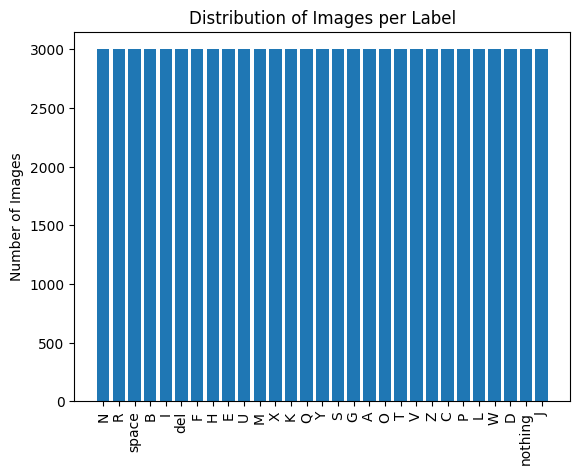

In [5]:
labels = os.listdir(train_dir)
counts = [len(os.listdir(os.path.join(train_dir, label))) for label in labels]

plt.bar(labels, counts)
plt.xticks(rotation=90)
plt.title('Distribution of Images per Label')
plt.ylabel('Number of Images')
plt.show()

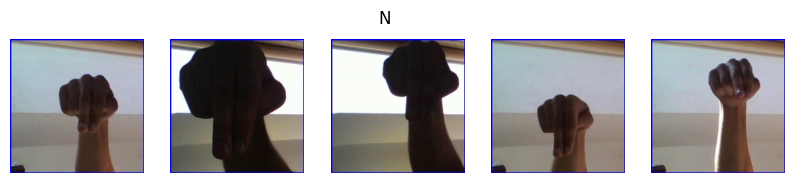

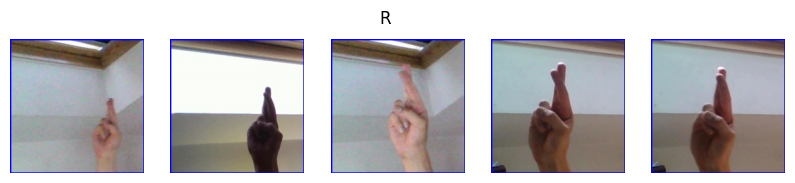

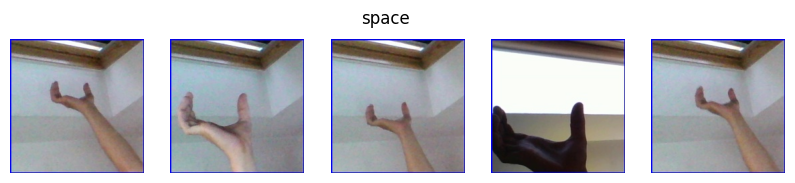

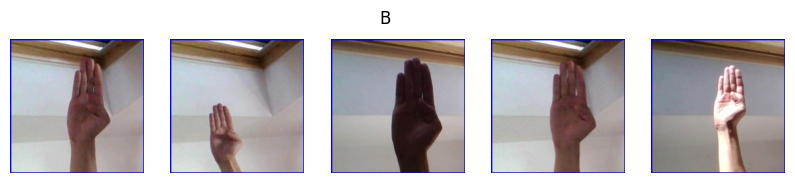

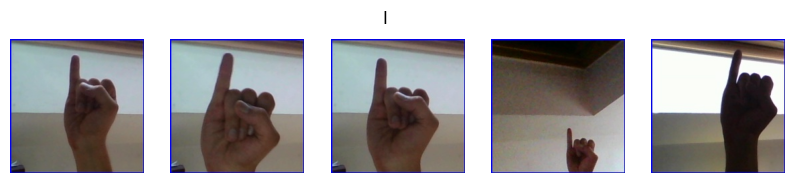

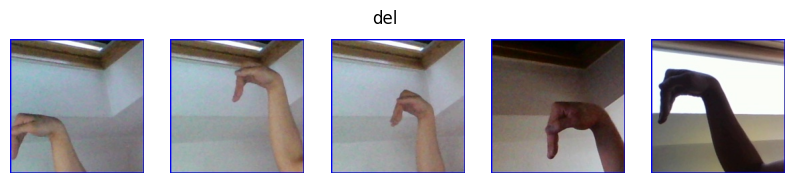

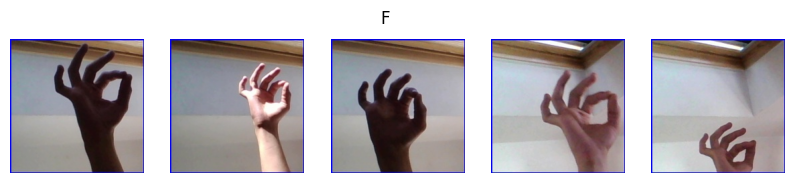

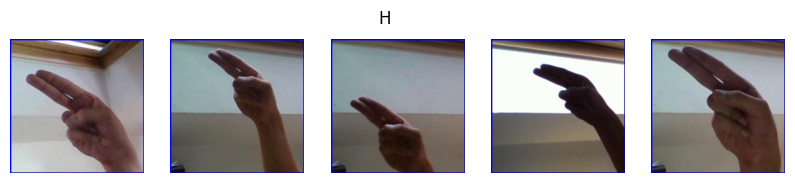

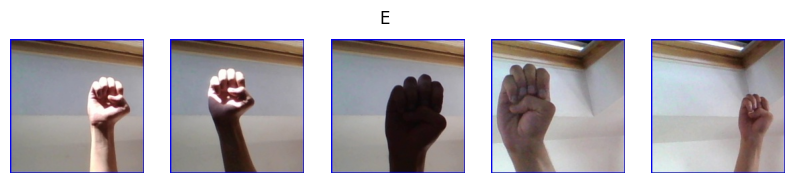

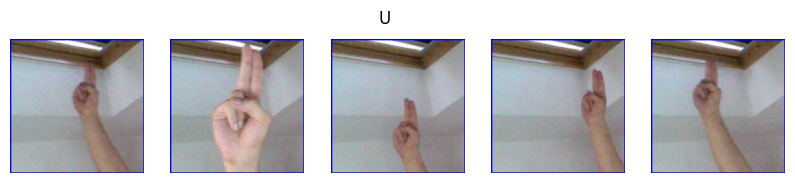

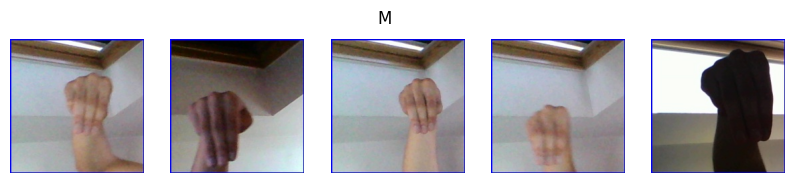

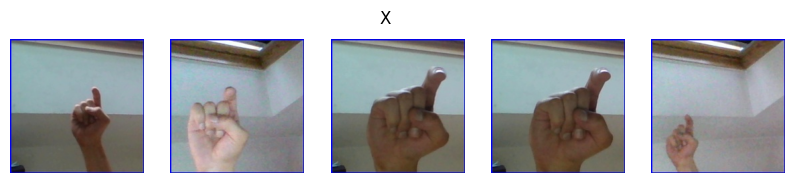

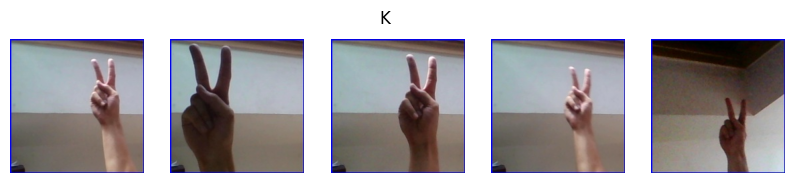

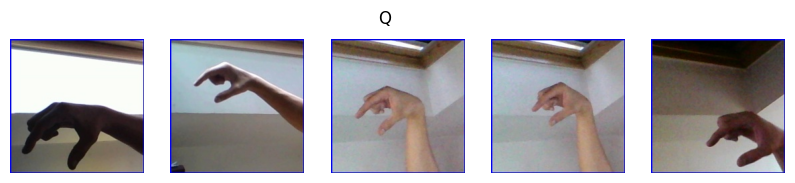

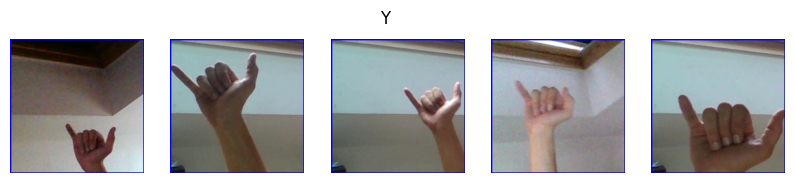

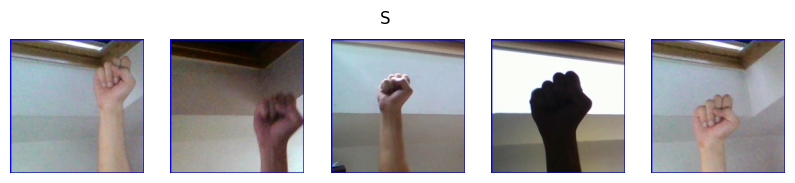

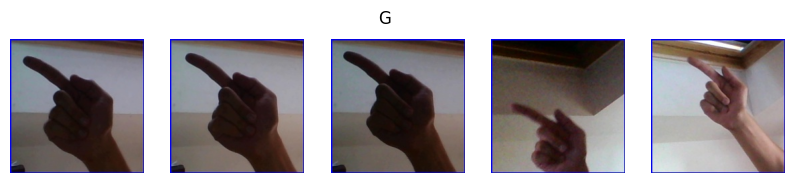

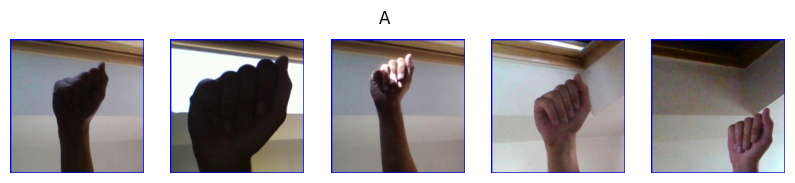

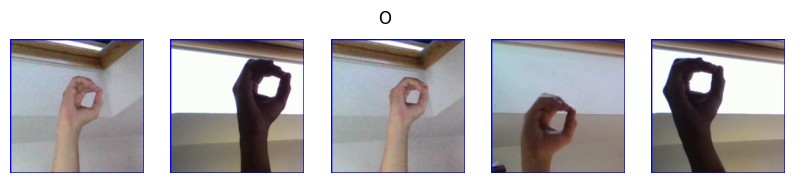

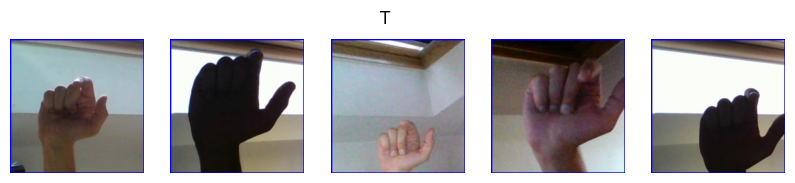

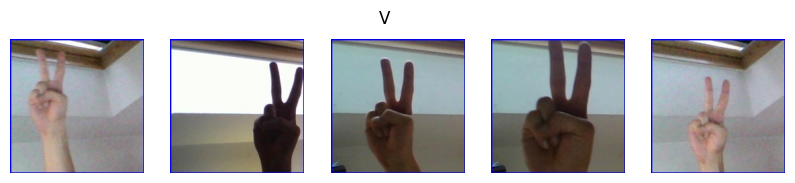

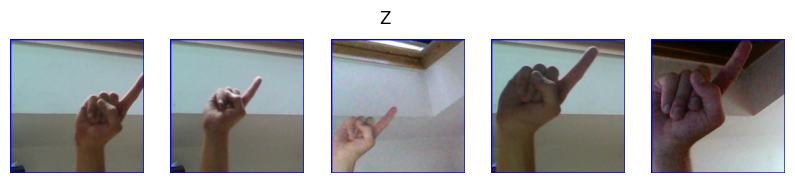

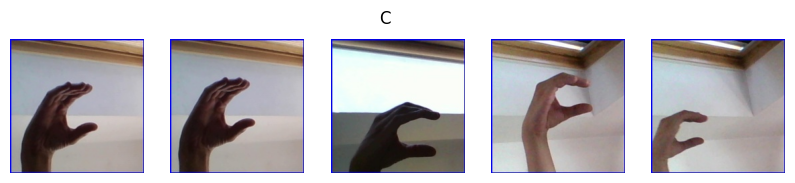

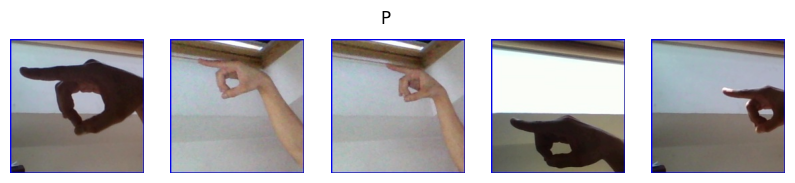

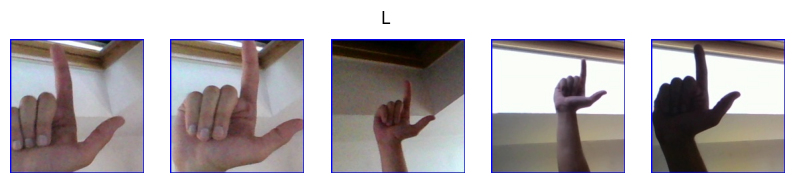

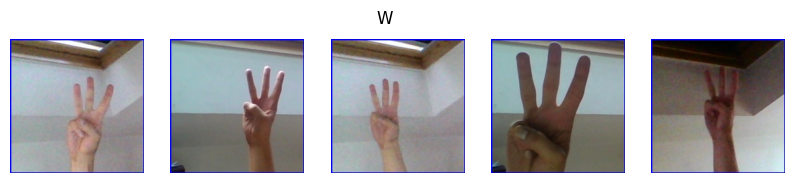

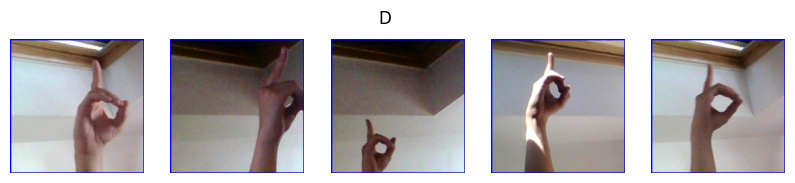

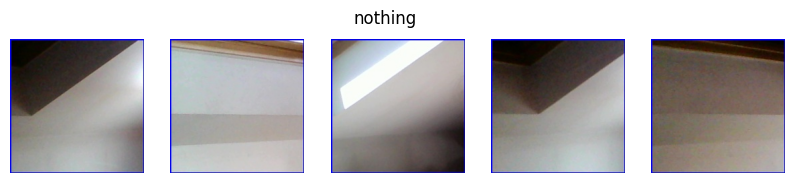

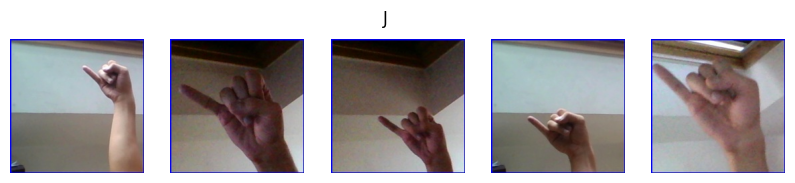

In [6]:
for label in labels:
    images = os.listdir(os.path.join(train_dir, label))
    plt.figure(figsize=(10, 2))
    for i in range(5):  # Display 5 random images
        img_path = os.path.join(train_dir, label, random.choice(images))
        img = plt.imread(img_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(label)
    plt.show()

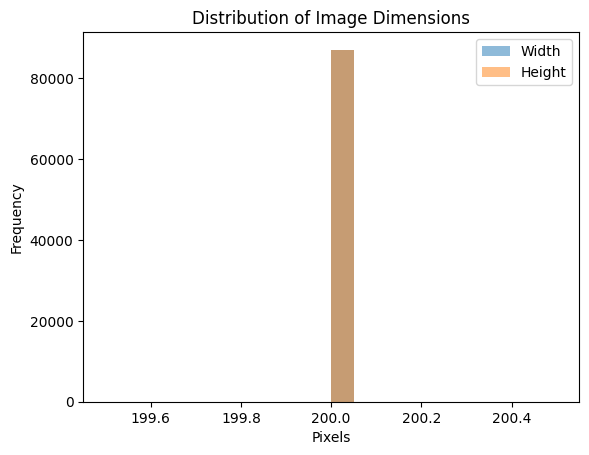

In [7]:
# image_sizes = []
# for label in labels:
#     images = os.listdir(os.path.join(train_dir, label))
#     for img_name in images:
#         img_path = os.path.join(train_dir, label, img_name)
#         with Image.open(img_path) as img:
#             image_sizes.append(img.size)

# width, height = zip(*image_sizes)
# plt.hist(width, bins=20, alpha=0.5, label='Width')
# plt.hist(height, bins=20, alpha=0.5, label='Height')
# plt.legend()
# plt.title('Distribution of Image Dimensions')
# plt.xlabel('Pixels')
# plt.ylabel('Frequency')
# plt.show()

In [9]:
image_path = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/B/B100.jpg'

# Open the image
with Image.open(image_path) as img:
    # Get the shape
    width, height = img.size
    print(f"The shape of the image is: (Height: {height}, Width: {width})")
    print(f"Channels of image: {img.mode}")

The shape of the image is: (Height: 200, Width: 200)
Channels of image: RGB


* All images have same Height and Width 200 * 200 and Same Channels 3 RGB

### Data preprocessing and augmentation

In [21]:
# Training data generator
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.15,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.1
)

# Validation data generator
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, 
    validation_split=0.1
    
)

# Create generators
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

val_gen = val_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle=False

)

print(f"Training samples: {train_gen.n}")
print(f"Validation samples: {val_gen.n}")


Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.
Training samples: 78300
Validation samples: 8700


### Phase 1 building Transfer Learning Model (MobileNetV2)

In [10]:
# Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False 

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  
predictions = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=5, 
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        "asl_mobilenetv2_best.h5", 
        save_best_only=True,
        monitor='val_loss',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.3, 
        patience=3, 
        verbose=1,
        min_lr=1e-7
    )
]



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


* include_top=False: You are cutting off the "head" of the expert. The original model was trained to recognize elephants and cars. You are removing that part so you can teach it ASL instead.

In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,593,373 (9.89 MB)

 Trainable params: 335,389 (1.28 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [21]:
print("\n" + "="*50)
print("PHASE 1: Training with frozen base model")
print("="*50 + "\n")

history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=callbacks
)


PHASE 1: Training with frozen base model



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1763276092.899527     179 service.cc:148] XLA service 0x7c0030210770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763276092.900239     179 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763276093.887869     179 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1224 ━━━━━━━━━━━━━━━━━━━━ 4:45:18 14s/step - accuracy: 0.0000e+00 - loss: 4.1470

I0000 00:00:1763276098.569591     179 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1224/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6322 - loss: 1.2653
Epoch 1: val_loss improved from inf to 0.36488, saving model to asl_mobilenetv2_best.h5
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 1559s 1s/step - accuracy: 0.6323 - loss: 1.2649 - val_accuracy: 0.8897 - val_loss: 0.3649 - learning_rate: 0.0010
Epoch 2/20
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 859ms/step - accuracy: 0.8841 - loss: 0.3602
Epoch 2: val_loss improved from 0.36488 to 0.24944, saving model to asl_mobilenetv2_best.h5
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 1084s 885ms/step - accuracy: 0.8841 - loss: 0.3602 - val_accuracy: 0.9184 - val_loss: 0.2494 - learning_rate: 0.0010
Epoch 3/20
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.9036 - loss: 0.2946
Epoch 3: val_loss did not improve from 0.24944
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 1086s 887ms/step - accuracy: 0.9036 - loss: 0.2946 - val_accuracy: 0.9080 - val_loss: 0.3153 - learning_rate: 0.0010
Epoch 4/20
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 859ms/step - accuracy: 0.9147 -

In [22]:
# model.save("asl_model_phase1.h5")
# print("\nPhase 1 model saved as 'asl_model_phase1.h5'")


Phase 1 model saved as 'asl_model_phase1.h5'


### Evaluation Phase 1

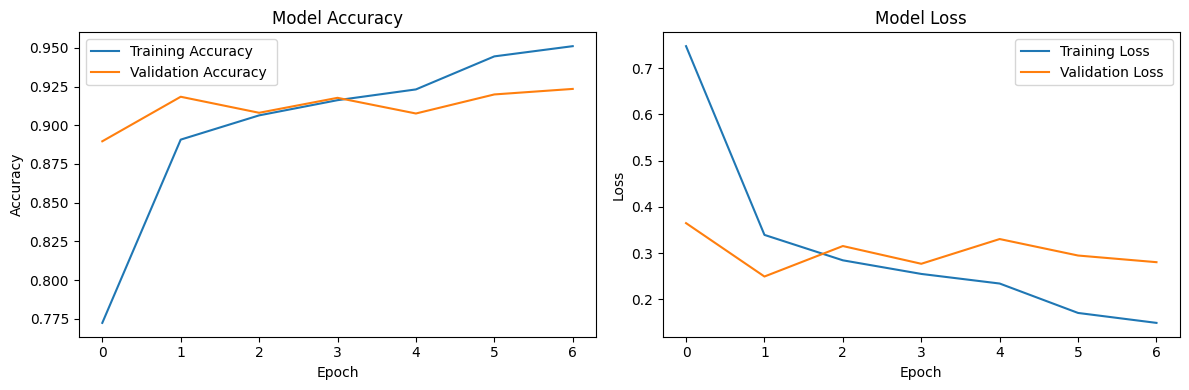


TRAINING COMPLETE!
Final Training Accuracy: 0.9510
Final Validation Accuracy: 0.9234


In [23]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy ')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')


# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss ')
plt.plot(history.history['val_loss'], label='Validation Loss ')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

print("\n" + "="*50)
print("TRAINING COMPLETE!")
print("="*50)
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")


### Phase 2: Fine-Tuning MobileNetV2 Model

In [24]:
print("\n" + "="*50)
print("PHASE 2: Fine-tuning the model")
print("="*50 + "\n")

# Unfreeze the base model
base_model.trainable = True

# Freeze early layers, only train last 30 layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)





PHASE 2: Fine-tuning the model



In [25]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,593,373 (9.89 MB)

 Trainable params: 1,861,789 (7.10 MB)

 Non-trainable params: 731,584 (2.79 MB)

### Traning Model After Fine-Tuning

In [26]:
# Train again
history_fine = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=callbacks
)

Epoch 1/10


E0000 00:00:1763284266.199901     180 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763284266.398921     180 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 402/1224 ━━━━━━━━━━━━━━━━━━━━ 11:32 843ms/step - accuracy: 0.8753 - loss: 0.4004

E0000 00:00:1763284610.400918     180 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763284610.601156     180 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1224/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - accuracy: 0.9229 - loss: 0.2455
Epoch 1: val_loss did not improve from 0.24944
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 1118s 898ms/step - accuracy: 0.9229 - loss: 0.2454 - val_accuracy: 0.9366 - val_loss: 0.2628 - learning_rate: 1.0000e-04
Epoch 2/10
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - accuracy: 0.9851 - loss: 0.0459
Epoch 2: val_loss improved from 0.24944 to 0.18108, saving model to asl_mobilenetv2_best.h5
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 1094s 893ms/step - accuracy: 0.9851 - loss: 0.0459 - val_accuracy: 0.9563 - val_loss: 0.1811 - learning_rate: 1.0000e-04
Epoch 3/10
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.9910 - loss: 0.0291
Epoch 3: val_loss did not improve from 0.18108
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 1087s 888ms/step - accuracy: 0.9910 - loss: 0.0291 - val_accuracy: 0.9574 - val_loss: 0.1813 - learning_rate: 1.0000e-04
Epoch 4/10
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.9934 - loss: 0.0206
Epoch 4: 

In [27]:
# model.save("asl_model_phase2_final.h5")
# print("\n Final model saved as 'asl_gesture_model_final.h5'")



 Final model saved as 'asl_gesture_model_final.h5'


### Evaluation Phase2

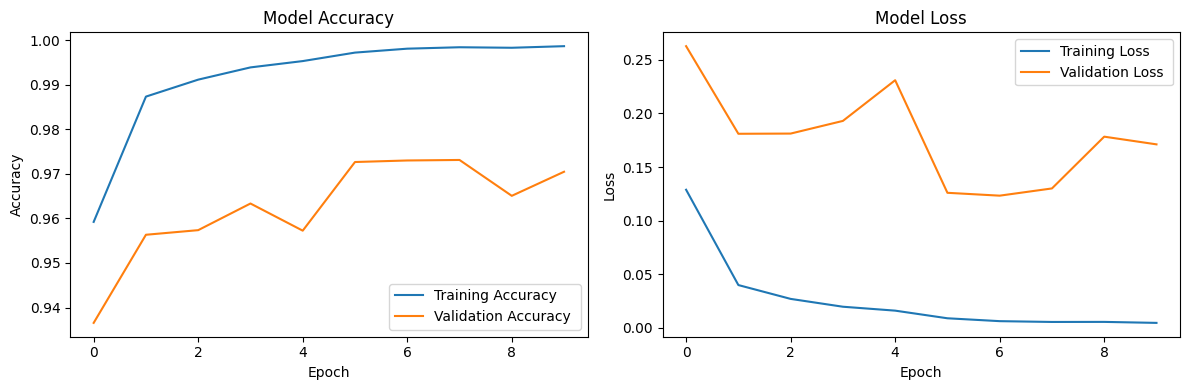


TRAINING COMPLETE!
Final Training Accuracy: 0.9986
Final Validation Accuracy: 0.9705


In [29]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_fine.history['accuracy'], label='Training Accuracy ')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')


# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_fine.history['loss'], label='Training Loss ')
plt.plot(history_fine.history['val_loss'], label='Validation Loss ')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

print("\n" + "="*50)
print("TRAINING COMPLETE!")
print("="*50)
print(f"Final Training Accuracy: {history_fine.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history_fine.history['val_accuracy'][-1]:.4f}")


### Comparsions between phase 1 & phase 2

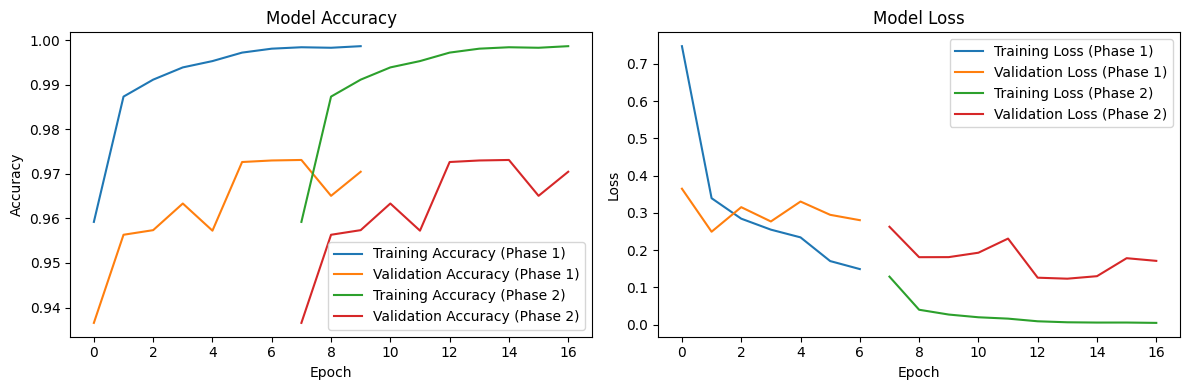


TRAINING COMPLETE!
Final Training Accuracy: 0.9986
Final Validation Accuracy: 0.9705


In [31]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_fine.history['accuracy'], label='Training Accuracy (Phase 1)')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy (Phase 1)')
if history_fine:
    plt.plot(range(len(history.history['accuracy']), 
                   len(history.history['accuracy']) + len(history_fine.history['accuracy'])),
             history_fine.history['accuracy'], label='Training Accuracy (Phase 2)')
    plt.plot(range(len(history.history['accuracy']), 
                   len(history.history['accuracy']) + len(history_fine.history['accuracy'])),
             history_fine.history['val_accuracy'], label='Validation Accuracy (Phase 2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss (Phase 1)')
plt.plot(history.history['val_loss'], label='Validation Loss (Phase 1)')
if history_fine:
    plt.plot(range(len(history.history['loss']), 
                   len(history.history['loss']) + len(history_fine.history['loss'])),
             history_fine.history['loss'], label='Training Loss (Phase 2)')
    plt.plot(range(len(history.history['loss']), 
                   len(history.history['loss']) + len(history_fine.history['loss'])),
             history_fine.history['val_loss'], label='Validation Loss (Phase 2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

print("\n" + "="*50)
print("TRAINING COMPLETE!")
print("="*50)
print(f"Final Training Accuracy: {history_fine.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history_fine.history['val_accuracy'][-1]:.4f}")

* we will depend on the best model from phase 2 that obtained from epoch number 7

In [24]:
model = load_model("/kaggle/input/best-mobilenetv2-model/tensorflow2/default/1/asl_mobilenetv2_best (1).h5")


In [30]:
val_loss, val_acc = model.evaluate(val_gen, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

steps = int(np.ceil(val_gen.n / val_gen.batch_size))
y_prob = model.predict(val_gen, steps=steps, verbose=1)

y_pred = np.argmax(y_prob, axis=1)
y_true = val_gen.classes

# class names
idx2class = {v: k for k, v in val_gen.class_indices.items()}
class_names = [idx2class[i] for i in range(len(idx2class))]


print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


136/136 ━━━━━━━━━━━━━━━━━━━━ 24s 176ms/step - accuracy: 0.9878 - loss: 0.0511
Validation Loss: 0.1234
Validation Accuracy: 0.9730
136/136 ━━━━━━━━━━━━━━━━━━━━ 23s 171ms/step

Classification Report:

              precision    recall  f1-score   support

           A       0.99      1.00      1.00       300
           B       1.00      1.00      1.00       300
           C       1.00      1.00      1.00       300
           D       1.00      1.00      1.00       300
           E       0.92      1.00      0.96       300
           F       1.00      1.00      1.00       300
           G       1.00      1.00      1.00       300
           H       1.00      1.00      1.00       300
           I       1.00      0.91      0.95       300
           J       1.00      1.00      1.00       300
           K       1.00      0.99      0.99       300
           L       1.00      1.00      1.00       300
           M       0.99      1.00      1.00       300
           N       0.96      1.00      0.98 

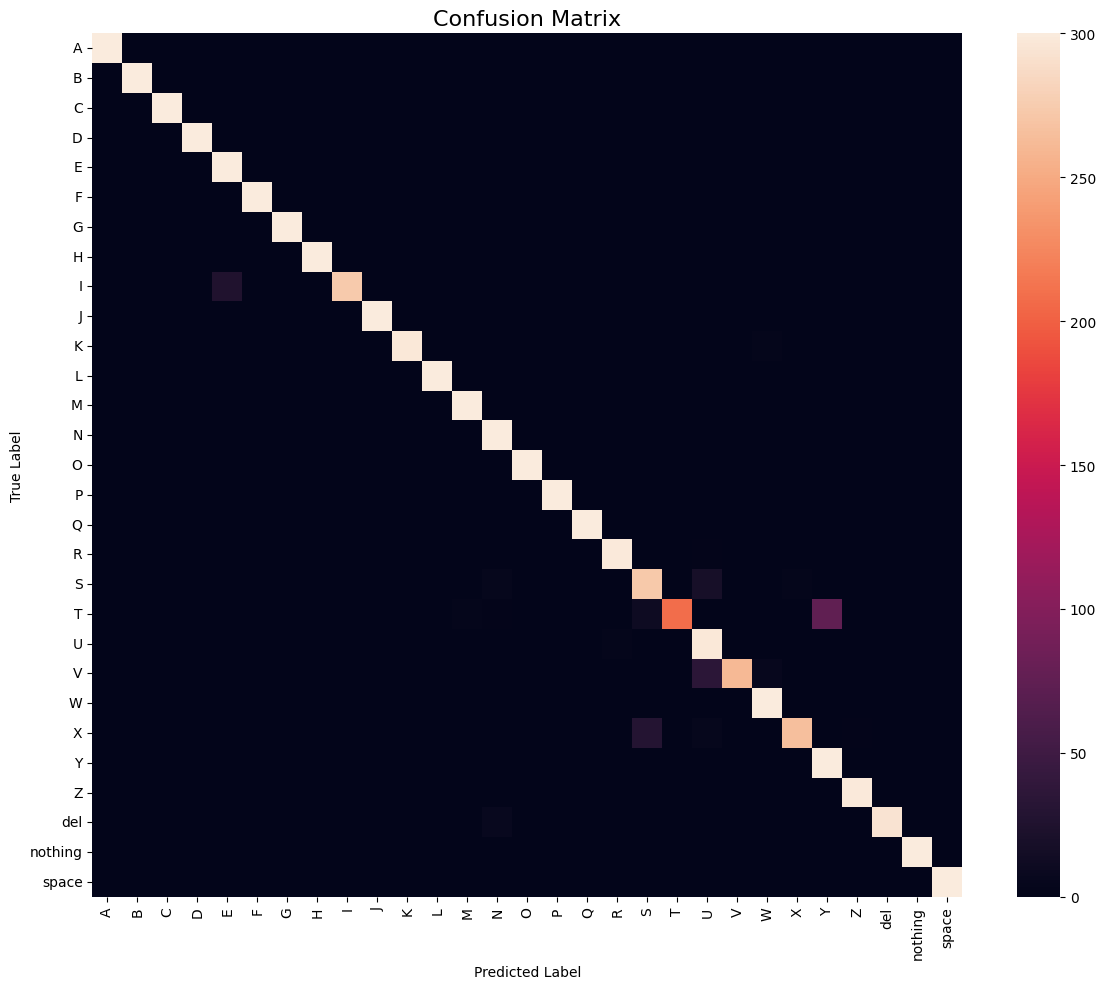

In [31]:
cm = confusion_matrix(y_true, y_pred)

cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm, 
            annot=False,        
            xticklabels=class_names, 
            yticklabels=class_names)

plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

###  Predictions on new samples
*  upload new image from anywhere you can capture this image by yourself and make test for model

In [32]:
img_path = '/kaggle/input/testletterw/testletterw.jpg'


img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

pred = model.predict(x)
predicted_class = np.argmax(pred)

labels = list(train_gen.class_indices.keys())
predicted_label = labels[predicted_class]

true_label = "W"
if predicted_label == true_label:
    print(f"Correct! The letter is {predicted_label}")
else:
    print(f"Incorrect! Predicted: {predicted_label}, True: {true_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Correct! The letter is W
